In [1]:
import matplotlib.pyplot as plt
import loss
import tensorflow.keras as kr
import tensorflow as tf
import os
import numpy as np
from datetime import datetime
%matplotlib inline


In [2]:
class Residual(kr.layers.Layer): 
    def __init__(self, 
                 num_channels, 
                 use_1x1conv=False, 
                 strides=1):
        super().__init__()
        
        self.conv1 = kr.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides,
            kernel_initializer = kr.initializers.GlorotNormal())
        self.conv2 = kr.layers.Conv2D(
            num_channels, kernel_size=3, padding='same',
            kernel_initializer = kr.initializers.GlorotNormal())
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = kr.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides,
                kernel_initializer = kr.initializers.GlorotNormal())
        self.bn1 = kr.layers.GroupNormalization(groups=num_channels)
        self.bn2 = kr.layers.GroupNormalization(groups=num_channels)
        #self.bn1 = kr.layers.BatchNormalization()
        #self.bn2 = kr.layers.BatchNormalization()

    def call(self, X):
        Y = kr.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return kr.activations.relu(Y)


class ResidualT(kr.layers.Layer): 
    def __init__(self, 
                 num_channels, 
                 strides=2):
        super().__init__()
        
        self.conv1 = kr.layers.Conv2DTranspose(
            num_channels, padding='same', kernel_size=4, strides=strides,
            kernel_initializer = kr.initializers.GlorotNormal())
       
        self.bn1 = kr.layers.GroupNormalization(groups=num_channels)
        #self.bn1 = kr.layers.BatchNormalization()
     

    def call(self, X):
        return kr.activations.relu(self.bn1(self.conv1(X)))
       

In [3]:
class ResnetBlock(kr.layers.Layer):
    def __init__(self, 
                 num_channels, 
                 num_residuals, 
                 first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                x = Residual(num_channels, use_1x1conv=True, strides=2)
                self.residual_layers.append(x)
            else:
                x = Residual(num_channels)
                self.residual_layers.append(x)

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

class ResnetBlockT(kr.layers.Layer):
    def __init__(self, 
                 num_channels, 
                 num_residuals, 
                 **kwargs):
        super(ResnetBlockT, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            x = ResidualT(num_channels, strides=2)
            self.residual_layers.append(x)

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [4]:
class EncoderModule(kr.Model): 
    def __init__(self, 
                 channels, 
                 filter_size,  
                 image_shape,
                 **kwargs):
        
        super().__init__(**kwargs)

        #define encoder
        self.encoder = kr.models.Sequential()
        self.encoder._name = "Encoder"

        #first conv
        self.b1 = [kr.layers.Conv2D(channels, kernel_size=5, strides=2, padding='same', 
                                    input_shape=image_shape, name="Conv1"),
                   kr.layers.GroupNormalization(groups=channels, name='BN1'),
                   #kr.layers.BatchNormalization(name='BN1'),
                   kr.layers.Activation('relu', name='Relu'),
                   kr.layers.MaxPool2D(pool_size=3, strides=2, 
                                       padding='same', name='MaxPool')]
        
        for layer in self.b1:
            self.encoder.add(layer)

        #second block
        b2 = ResnetBlock(channels, 2, first_block=True)
        b2._name ='ResBlock_2'
        self.encoder.add(b2)

        for i in range(1, 4):
            b = ResnetBlock(int(2 ** (i + 6)), 2)
            b._name = f"ResBlock_{i+2}"
            self.encoder.add(b)

    def call(self, inputs__):
        return self.encoder(inputs__)


In [5]:
for i in range(1, 8):
    if i < 4:
        print(int(2 ** (i + 6)))
    else:
        print(int(2 ** (3 + 6)))


128
256
512
512
512
512
512


In [6]:
class DecoderModule(kr.Model): 
    def __init__(self, 
                 channels, 
                 filter_size,  
                 **kwargs):
        
        super().__init__(**kwargs)

        #define encoder
        self.decoder = kr.models.Sequential()
        self.decoder._name = "Decoder"
        self.decoder.add(ResnetBlockT(channels//4, 1))
        self.decoder.add(ResnetBlockT(channels//2, 1))
        self.decoder.add(ResnetBlockT(channels//2, 1))
        self.decoder.add(ResnetBlockT(channels, 1))


    def call(self, inputs__):
        return self.decoder(inputs__)

In [7]:
class p2p_generator(kr.Model):
    def __init__(self, **kwargs):
        
        super().__init__(**kwargs)

        self.encoder = EncoderModule(channels=64, 
                                        filter_size=3,
                                        image_shape=(256,256,1))
        
        self.decoder = DecoderModule(channels=256, 
                                        filter_size=4)
        
        self.convT = kr.layers.Conv2DTranspose(1, 
                                               5, 
                                               strides=2, 
                                               padding='same')
        

    def call(self, input__):
        return kr.activations.sigmoid(self.convT(self.decoder(self.encoder(input__))))

In [8]:
class Discriminator(kr.Model):
	def __init__(self, flags, **kwargs):
		super().__init__(**kwargs)
		self.image_shape = (flags.crop_size, flags.crop_size, 1)
		n_filters = flags.disc_n_filters
		filter_size = flags.disc_filter_size
		self.merged = kr.layers.Concatenate()
		self.downsample1 = Residual(n_filters, use_1x1conv=True, strides=2)
		self.downsample2 = ResnetBlock(2*n_filters, 1)
		self.downsample3 = ResnetBlock(4*n_filters, 1)
		self.downsample4 = ResnetBlock(8*n_filters, 1)
		self.conv = kr.layers.Conv2D(self.image_shape[-1], kernel_size=filter_size, padding='same')
        
	
	def call(self, inputs_, **kwargs):
		#print(f"{'=='.join(['#' for i in range (10)])}\n{inputs_[0].shape},\n {inputs_[1].shape}")
		x = self.merged([inputs_[0], inputs_[1]])
		x1 = self.downsample1(x)
		x2 = self.downsample2(x1)
		x3 = self.downsample3(x2)
		x4 = self.downsample4(x3)
		x5 = self.conv(x4)
		return [x1, x2, x3, x4, x5]

In [9]:
class P2PMonitor(kr.callbacks.Callback):
	def __init__(self, val_dataset, flags, my_strategy=False):
		self.val_images = next(iter(val_dataset))
		self.my_strategy = my_strategy
		self.n_samples = 1
		self.epoch_interval = 2
		self.checkpoints_path = os.path.join(flags.checkpoints_dir, flags.name)
		self.sample_dir = os.path.join(flags.sample_dir, flags.name)

		if not os.path.exists(self.checkpoints_path):
			os.makedirs(self.checkpoints_path)
		if not os.path.exists(self.sample_dir):
			os.makedirs(self.sample_dir)

	def infer(self):
		if self.my_strategy:
			#@tf.function
			def inferx(c):
				return self.model(c)
				
			all_replicas = self.my_strategy.experimental_local_results(self.val_images)
			self.val_images = all_replicas[0]
			predictions = inferx(self.val_images[0])
			#print(f"\n{self.val_images[0].shape}")
			#values = self.my_strategy.experimental_local_results(predictions)
			return predictions
		else:
			
			return self.model(self.val_images[0])

	def on_epoch_end(self, epoch, logs=None):
		if epoch > 0 and epoch % self.epoch_interval == 0:
			#self.save_models()
			generated_images = self.infer()
			for s_ in range(self.n_samples):
				grid_row = min(generated_images.shape[0], 3)
				f, axarr = plt.subplots(grid_row, 3, figsize=(18, grid_row * 6))
				for row in range(grid_row):
					ax = axarr if grid_row == 1 else axarr[row]
					ax[0].imshow((self.val_images[0][row].numpy().squeeze()), cmap='gray')
					ax[0].axis("off")
					ax[0].set_title("CT", fontsize=20)
					ax[1].imshow((self.val_images[1][row].numpy().squeeze()), cmap='gray')
					ax[1].axis("off")
					ax[1].set_title("Ground Truth", fontsize=20)
					ax[2].imshow((np.array(generated_images[row]).squeeze()), cmap='gray')
					ax[2].axis("off")
					ax[2].set_title("Generated", fontsize=20)
				filename = "sample_{}_{}_{}.png".format(epoch, s_, datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
				sample_file = os.path.join(self.sample_dir, filename)
				plt.savefig(sample_file)
				plt.show()

In [10]:
class Flags():
    def __int__(self):
        self.initialized = False
        self.initalize()
        return 0

    def initalize(self):
        self.apply_normalization= False                          
        self.batch_size= 1                              
        self.checkpoints_dir= './checkpoints'                  
        self.crop_size= 256                            
        self.d_res_filters= 1024                           
        self.data_path= '/media/aisec1/DATA3/rachel/PCGAN/data/folds1234.npz' 
        self.data_test_rate= 0.2                            
        self.disc_beta_1= 0.0                            
        self.disc_beta_2= 0.999                          
        self.disc_filter_size= 4                              
        self.disc_lr= 0.0001                         
        self.disc_n_filters= 64                             
        self.disc_strides= 2                              
        self.e_filter_size= 3                              
        self.e_n_filters= 64                             
        self.e_strides= 2                              
        self.edge_threshold= 0.03                           
        self.epoch_interval= 2                             
        self.epochs= 10                            
        self.feature_loss_coeff= 10.0                           
        self.gen_beta_1= 0.0                            
        self.gen_beta_2= 0.999                          
        self.gen_lr= 0.0001                         
        self.gpu_ids= 1                             
        self.isTrain= True                      
        self.kl_divergence_loss_coeff= 0.1                            
        latent_dim= 256                            
        self.load_from_opt_file= False                          
        self.load_size= 256                            
        self.loss_weights= [1 , 100]                       
        self.model_path= '/media/aisec1/DATA3/rachel/PCGAN/models/Pix2Pix_fold1234' 
        self.name= 'pix2pix_fold1234'                   
        self.phase= 'train'                          
        self.remove_bad_images= True                           
        self.result_log= 'results.log'                    
        self.result_logs= './results'                     
        self.s_beta_filter_size= 3                              
        self.s_beta_filters= 128                            
        self.s_epsilon= 1e-05                          
        self.s_gamma_filter_size= 3                              
        self.s_gamma_filters= 128                            
        self.sample_dir= './training_samples'             
        self.test_data_path= '/media/aisec1/DATA3/Bibo2/Project/CT2MRI/dataset/CV/fold5.npz' 
        self.vgg_feature_loss_coeff= 0.1  

        print('done!')
        return 0


flags = Flags()
flags.initalize()

done!


0

In [11]:

class pix2pix(kr.Model):
    def __init__(self, flags,strategy=False, **kwargs):
        
        super().__init__(**kwargs)
        self.experiment_name = "debugp2p" #flags.name
        self.flags = flags
        #self.samples_dir = flags.sample_d
        #self.models_dir = flags.checkpoints_dir
        self.image_shape = (256, 256, 1) #(flags.crop_size, flags.crop_size, 1)
        self.image_size = 256 #flags.crop_size
        self.batch_size = 1 #flags.batch_size

        self.feature_loss_coeff = 4 #flags.feature_loss_coeff
        self.vgg_feature_loss_coeff = 1 #flags.vgg_feature_loss_coeff
        self.generator_loss_coeff = 1
        self.ssim_loss_coeff = 2
        self.mae_loss_coeff = 10
        
        self.discriminator = Discriminator(flags)
        self.generator = p2p_generator()
        self.patch_size, self.combined_model = self.build_combined_model()
        # gen_lr = 0.0002, gen_beta_1 = 0.5
        self.generator_optimizer = kr.optimizers.Adam(self.flags.gen_lr, beta_1=self.flags.gen_beta_1)
        self.discriminator_optimizer = kr.optimizers.Adam(self.flags.disc_lr, beta_1=self.flags.gen_beta_1)
        self.discriminator_loss = loss.DiscriminatorLoss()
        self.feature_matching_loss = loss.FeatureMatchingLoss()
        self.vgg_loss = loss.VGGFeatureMatchingLoss()
        self.mae_loss = loss.MAE()

        self.disc_loss_tracker = tf.keras.metrics.Mean(name="disc_loss")
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.feat_loss_tracker = tf.keras.metrics.Mean(name="feat_loss")
        self.vgg_loss_tracker = tf.keras.metrics.Mean(name="vgg_loss")
        self.ssim_loss_tracker = tf.keras.metrics.Mean(name="ssim_loss")
        self.mae_loss_tracker = tf.keras.metrics.Mean(name="mae_loss")


        

    @property
    def metrics(self):
        return [
            self.disc_loss_tracker,
            self.gen_loss_tracker,
            self.feat_loss_tracker,
            self.vgg_loss_tracker,
            self.ssim_loss_tracker,
            self.mae_loss_tracker]

    def build_combined_model(self):

        self.discriminator.trainable = False
        ct_input = kr.Input(shape=self.image_shape, name="ct")
        mri_input = kr.Input(shape=self.image_shape, name="mri")

        generated_mri = self.generator(ct_input)
        
        #print(generated_mri.shape)

        discriminator_outputs = self.discriminator([ct_input, generated_mri])
        patch_size = discriminator_outputs[-1].shape[1]
        combined_model = kr.Model(
            [ct_input, mri_input],
            [discriminator_outputs, generated_mri])

        return patch_size, combined_model


    def compile(self, **kwargs):
        super().compile(**kwargs)

    def train_discriminator(self, ct, real_mri):
        
        fake_mri = self.generator(ct)
        with tf.GradientTape() as gradient_tape:
            pred_fake = self.discriminator([ct, fake_mri])[-1]  # check
            pred_real = self.discriminator([ct, real_mri])[-1]  # check
            #print(f"{'#'.join(['#' for i in range(20)])}\n\n{pred_real.shape}\n\n")
            #fake_labels = np.zeros((1,16,16,1), dtype=int)
            #real_lables = np.ones((1,16,16,1), dtype=int)
            loss_fake = self.discriminator_loss(False, pred_fake)
            loss_real = self.discriminator_loss(True, pred_real)
            total_loss = 0.5 * (loss_fake + loss_real)

        self.discriminator.trainable = True
        gradients = gradient_tape.gradient(
            total_loss, self.discriminator.trainable_variables)


        self.discriminator_optimizer.apply_gradients(
            zip(gradients, self.discriminator.trainable_variables)
        )

        return total_loss

    def train_generator(self, ct, mri__):

        self.discriminator.trainable = False
        with tf.GradientTape() as tape:
            fake_d_output, fake_mri = self.combined_model([ct, mri__])
            real_d_output = self.discriminator([ct, mri__])  # check

            #fake_d_output = fake_d_output[-1].shape[1]
            pred = fake_d_output[-1]
            
            # Compute generator loss
            g_loss = self.generator_loss_coeff*loss.generator_loss(pred)
            vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(mri__, fake_mri)
            feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
                real_d_output, fake_d_output
            )
            ssim_loss = self.ssim_loss_coeff * loss.SSIMLoss(mri__, fake_mri)
            mae_loss = self.mae_loss_coeff * self.mae_loss(mri__, fake_mri)
            total_loss = g_loss + vgg_loss + feature_loss + ssim_loss + mae_loss
            
        all_trainable_variables = (
            self.combined_model.trainable_variables
        )

        gradients = tape.gradient(total_loss, all_trainable_variables)

        self.generator_optimizer.apply_gradients(
            zip(gradients, all_trainable_variables)
        )

        return total_loss, vgg_loss, feature_loss, ssim_loss, mae_loss


    def train_step(self, data):

        ct, mri = data
        
        discriminator_loss = self.train_discriminator(ct, mri)
        (generator_loss, vgg_loss, feature_loss, ssim_loss, mae_loss) = self.train_generator(ct, mri)

        # Report progress.
        self.disc_loss_tracker.update_state(discriminator_loss)
        self.gen_loss_tracker.update_state(generator_loss)
        self.feat_loss_tracker.update_state(feature_loss)
        self.vgg_loss_tracker.update_state(vgg_loss)
        self.ssim_loss_tracker.update_state(ssim_loss)
        self.mae_loss_tracker.update_state(mae_loss)


        results = {m.name: m.result() for m in self.metrics}

        return results


    def test_step(self, data):

        ct, mri = data
        fake_mri = self.generator(ct)

        # Calculate the losses.
        pred_fake = self.discriminator([ct, fake_mri])[-1]  # check
        pred_real = self.discriminator([ct, mri])[-1]  # check
        #print(f"{'#'.join(['#' for i in range(20)])}\n\n{pred_real.shape}\n\n")
#         fake_labels = np.zeros((1,16,16,1), dtype=int)
#         real_lables = np.ones((1,16,16,1), dtype=int)
        loss_fake = self.discriminator_loss(False, pred_fake)
        loss_real = self.discriminator_loss(True, pred_real)
        total_discriminator_loss = 0.5 * (loss_fake + loss_real)

        real_d_output = self.discriminator([fake_mri, mri])
        fake_d_output, fake_image = self.combined_model([ct, mri])
        pred = fake_d_output[-1]
        g_loss = self.generator_loss_coeff*loss.generator_loss(pred)
        
        vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(mri, fake_image)
        feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
            real_d_output, fake_d_output)
        ssim_loss = self.ssim_loss_coeff * loss.SSIMLoss(mri, fake_image)
        mae_loss = self.mae_loss_coeff * self.mae_loss(mri, fake_mri)
        total_generator_loss = g_loss + vgg_loss + feature_loss + ssim_loss + mae_loss

        # Report progress.
        self.disc_loss_tracker.update_state(total_discriminator_loss)
        self.gen_loss_tracker.update_state(total_generator_loss)
        self.feat_loss_tracker.update_state(feature_loss)
        self.vgg_loss_tracker.update_state(vgg_loss)
        self.ssim_loss_tracker.update_state(ssim_loss)
        self.mae_loss_tracker.update_state(mae_loss)

        results = {m.name: m.result() for m in self.metrics}

        return results

    def call(self, inputs):
        return self.generator(inputs)

In [12]:
#Build and train the model

model = pix2pix(flags)
model.compile()
model.generator.summary()

Model: "p2p_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_module (EncoderModu  multiple                 11171712  
 le)                                                             
                                                                 
 decoder_module (DecoderModu  multiple                 1443520   
 le)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  multiple                 6401      
 ranspose)                                                       
                                                                 
Total params: 12,621,633
Trainable params: 12,621,633
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concatenate (Concatenate)   multiple                  0         
                                                                 
 residual (Residual)         multiple                  38592     
                                                                 
 resnet_block (ResnetBlock)  multiple                  230272    
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 919296    
 )                                                               
                                                                 
 resnet_block_2 (ResnetBlock  multiple                 3673600   
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          multiple                

In [14]:
import data_loader

test_dataset = data_loader.DataGenerator_PairedReady(flags, '/media/aisec-102/DATA3/Bibo2/Project/CT2MRI/dataset/CV/fold5.npz').load()
train_dataset = data_loader.DataGenerator_PairedReady(flags, '/media/aisec-102/DATA3/rachel/PCGAN/data/folds1234.npz').load()

#options = tf.data.Options()
#options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE

#train_dataset = train_dataset.with_options(options)
#test_dataset = test_dataset.with_options(options)



Epoch 1/100
1776/1776 [==============================] - 167s 78ms/step - disc_loss: 0.1111 - gen_loss: 84.4033 - feat_loss: 6.9237 - vgg_loss: 71.7936 - ssim_loss: 1.6110 - mae_loss: 1.2902 - val_disc_loss: 0.1433 - val_gen_loss: 100.4877 - val_feat_loss: 7.7271 - val_vgg_loss: 85.5259 - val_ssim_loss: 1.6940 - val_mae_loss: 1.3305
Epoch 2/100
1776/1776 [==============================] - 137s 77ms/step - disc_loss: 0.1046 - gen_loss: 78.5368 - feat_loss: 6.1448 - vgg_loss: 66.9317 - ssim_loss: 1.5179 - mae_loss: 1.1385 - val_disc_loss: 0.1308 - val_gen_loss: 91.3178 - val_feat_loss: 7.1375 - val_vgg_loss: 77.8006 - val_ssim_loss: 1.6093 - val_mae_loss: 1.2589
Epoch 3/100
1776/1776 [==============================] - ETA: 0s - disc_loss: 0.1100 - gen_loss: 76.6554 - feat_loss: 5.7662 - vgg_loss: 65.3900 - ssim_loss: 1.4784 - mae_loss: 1.0764

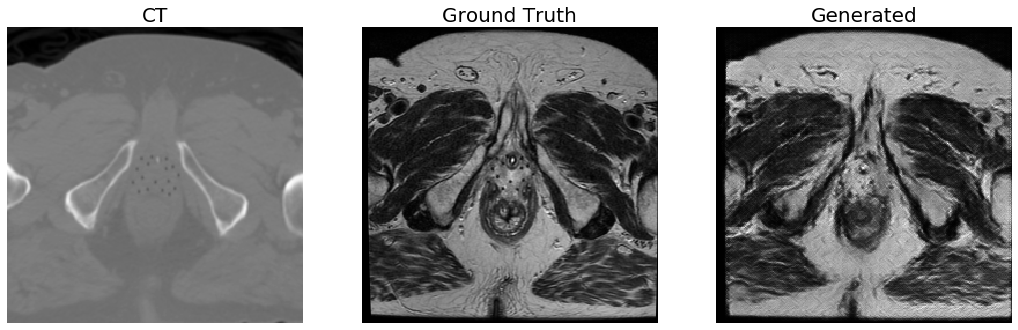

1776/1776 [==============================] - 137s 77ms/step - disc_loss: 0.1100 - gen_loss: 76.6554 - feat_loss: 5.7662 - vgg_loss: 65.3900 - ssim_loss: 1.4784 - mae_loss: 1.0764 - val_disc_loss: 0.0161 - val_gen_loss: 89.4181 - val_feat_loss: 6.7250 - val_vgg_loss: 77.1026 - val_ssim_loss: 1.5850 - val_mae_loss: 1.2210
Epoch 4/100
1776/1776 [==============================] - 134s 76ms/step - disc_loss: 0.1262 - gen_loss: 74.7403 - feat_loss: 5.4340 - vgg_loss: 63.8902 - ssim_loss: 1.4476 - mae_loss: 1.0305 - val_disc_loss: 0.0977 - val_gen_loss: 90.2952 - val_feat_loss: 6.3808 - val_vgg_loss: 76.7312 - val_ssim_loss: 1.5684 - val_mae_loss: 1.2012
Epoch 5/100
1776/1776 [==============================] - ETA: 0s - disc_loss: 0.1414 - gen_loss: 72.8445 - feat_loss: 5.1500 - vgg_loss: 62.3306 - ssim_loss: 1.4121 - mae_loss: 0.9845

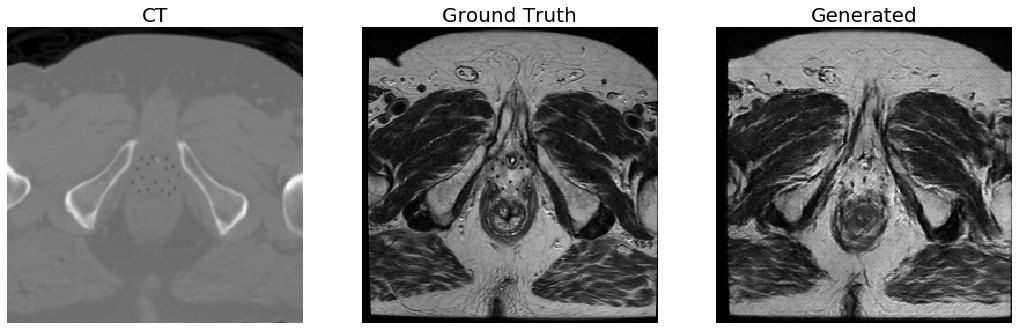

1776/1776 [==============================] - 137s 77ms/step - disc_loss: 0.1414 - gen_loss: 72.8445 - feat_loss: 5.1500 - vgg_loss: 62.3306 - ssim_loss: 1.4121 - mae_loss: 0.9845 - val_disc_loss: 0.1420 - val_gen_loss: 89.8359 - val_feat_loss: 6.1609 - val_vgg_loss: 76.9395 - val_ssim_loss: 1.5646 - val_mae_loss: 1.1943
Epoch 6/100
1776/1776 [==============================] - 135s 76ms/step - disc_loss: 0.1456 - gen_loss: 71.1052 - feat_loss: 4.9106 - vgg_loss: 60.8259 - ssim_loss: 1.3847 - mae_loss: 0.9422 - val_disc_loss: 0.1767 - val_gen_loss: 89.0002 - val_feat_loss: 5.9808 - val_vgg_loss: 76.9308 - val_ssim_loss: 1.5646 - val_mae_loss: 1.1975
Epoch 7/100
1776/1776 [==============================] - ETA: 0s - disc_loss: 0.1572 - gen_loss: 69.3745 - feat_loss: 4.7192 - vgg_loss: 59.3273 - ssim_loss: 1.3621 - mae_loss: 0.9065

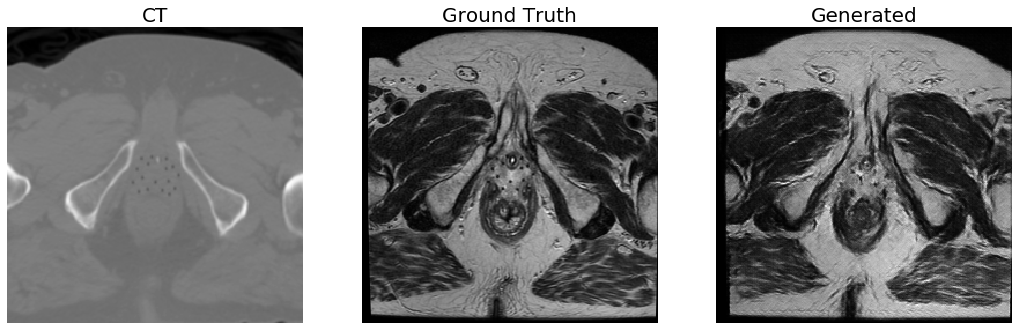

1776/1776 [==============================] - 135s 76ms/step - disc_loss: 0.1572 - gen_loss: 69.3745 - feat_loss: 4.7192 - vgg_loss: 59.3273 - ssim_loss: 1.3621 - mae_loss: 0.9065 - val_disc_loss: 0.2421 - val_gen_loss: 89.3335 - val_feat_loss: 5.8290 - val_vgg_loss: 76.2769 - val_ssim_loss: 1.5498 - val_mae_loss: 1.1899
Epoch 8/100
1776/1776 [==============================] - 135s 76ms/step - disc_loss: 0.1536 - gen_loss: 67.5625 - feat_loss: 4.5454 - vgg_loss: 57.7354 - ssim_loss: 1.3395 - mae_loss: 0.8799 - val_disc_loss: 0.1373 - val_gen_loss: 88.3647 - val_feat_loss: 5.7186 - val_vgg_loss: 76.4505 - val_ssim_loss: 1.5536 - val_mae_loss: 1.1750
Epoch 9/100
1776/1776 [==============================] - ETA: 0s - disc_loss: 0.1510 - gen_loss: 66.1618 - feat_loss: 4.3996 - vgg_loss: 56.4080 - ssim_loss: 1.3198 - mae_loss: 0.8549

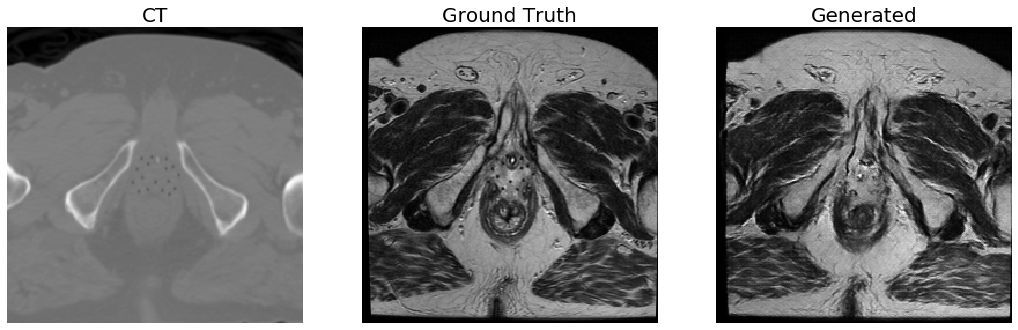

1776/1776 [==============================] - 135s 76ms/step - disc_loss: 0.1510 - gen_loss: 66.1618 - feat_loss: 4.3996 - vgg_loss: 56.4080 - ssim_loss: 1.3198 - mae_loss: 0.8549 - val_disc_loss: 0.1541 - val_gen_loss: 87.8149 - val_feat_loss: 5.6201 - val_vgg_loss: 76.1061 - val_ssim_loss: 1.5522 - val_mae_loss: 1.1646
Epoch 10/100
1776/1776 [==============================] - 137s 77ms/step - disc_loss: 0.1503 - gen_loss: 64.7435 - feat_loss: 4.2738 - vgg_loss: 55.1869 - ssim_loss: 1.3033 - mae_loss: 0.8334 - val_disc_loss: 0.5288 - val_gen_loss: 90.0737 - val_feat_loss: 5.5256 - val_vgg_loss: 75.8721 - val_ssim_loss: 1.5467 - val_mae_loss: 1.1658
Epoch 11/100
1776/1776 [==============================] - ETA: 0s - disc_loss: 0.1414 - gen_loss: 63.5029 - feat_loss: 4.1785 - vgg_loss: 54.0277 - ssim_loss: 1.2878 - mae_loss: 0.8162

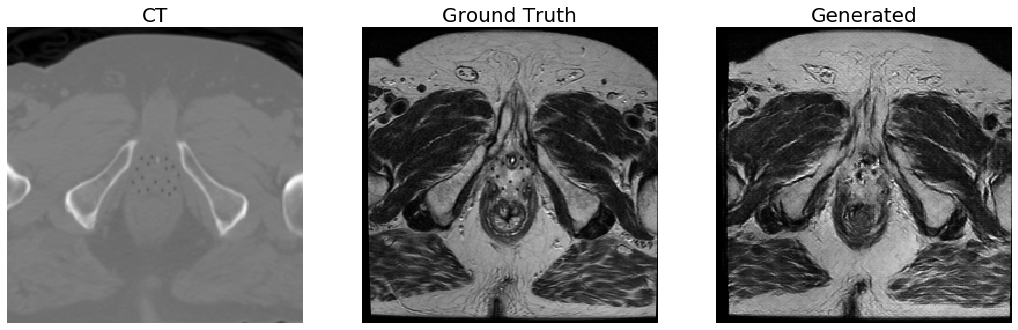

1776/1776 [==============================] - 135s 76ms/step - disc_loss: 0.1414 - gen_loss: 63.5029 - feat_loss: 4.1785 - vgg_loss: 54.0277 - ssim_loss: 1.2878 - mae_loss: 0.8162 - val_disc_loss: 0.1799 - val_gen_loss: 87.8760 - val_feat_loss: 5.4155 - val_vgg_loss: 75.9373 - val_ssim_loss: 1.5476 - val_mae_loss: 1.1535
Epoch 12/100
 295/1776 [===>..........................] - ETA: 1:36 - disc_loss: 0.1290 - gen_loss: 62.2134 - feat_loss: 4.1336 - vgg_loss: 52.7662 - ssim_loss: 1.2734 - mae_loss: 0.7932

KeyboardInterrupt: 

In [15]:
history = model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=100,
  callbacks=[P2PMonitor(test_dataset, flags)],
)